# 15. QLS - Multiple Linear Regression

Multiple linear regression generalizes linear regression, allowing the dependent variable to be a linear function of multiple independent variables. As before, we assume that $Y$ is a linear function of $X_{1}, ..., X_{k}$:

$Y_{i} = \beta_{0} + \beta_{1} X_{1i} + \ldots + \beta_{k} X_{ki} + \epsilon_{i}$

Often, in finance, the form will be written as follows (it's just the variable name that changes):

$Y_{i} = \alpha + \beta_{1} X_{1i} + \ldots + \beta_{k} X_{ki} + \epsilon_{i}$

For observations $i = 1, 2, \ldots, n$. In order to find the plane (or hyperplane) of best fit, we'll use the method of *ordinary least-squares* (OLS), which tries to minimize the squared error between predictions and observations, $\sum_{i=1}^{n} \epsilon_{2}^{i}$. The square makes positive and negative errors equally bad, and magnifies large errors. It also makes the closed form math behind linear regression nice, but we won't go into that now. E.g. with squared error we see the following.

In [36]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
from statsmodels import regression
import yfinance as yf

Let's say $Y$ is our actual data, and $\hat{Y}$ is the predictions made by linear regression.

In [37]:
Y = np.array([1, 3.5, 4, 8 ,12])
Y_hat = np.array([1, 3, 5, 7, 9])
# compute squared error
sqrt_error = (Y_hat - Y) ** 2

print("Error:", Y_hat - Y)
print("Squared Error:", sqrt_error)
print("Sum of Squared Error:", np.sum(sqrt_error))

Error: [ 0.  -0.5  1.  -1.  -3. ]
Squared Error: [0.   0.25 1.   1.   9.  ]
Sum of Squared Error: 11.25


Once we've used this method to determine the coefficients of the regression, we'll be able to use the new values of $X$ to predict $Y$.

Each coefficient $\beta_{j}$ tells us how much $Y_{i}$ will change if we change $X_{j}$ by one, while holding all the other dependent variables constant. This lets us separate out the contributions of different effects. This is assuming the linear model is the correct one.

We start by artificially constructing $Y$, $X_{1}$, and $X_{2}$ in which we know the precise relationship.

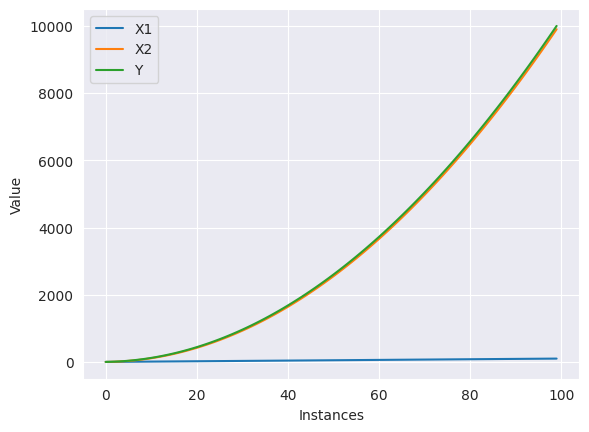

In [38]:
# construct a simple linear curve of 1, 2, ..., 100
X1 = np.arange(100)

# make a parabola and add X1 to it
X2 = np.array([i ** 2 for i in range(100)]) + X1

# this is our real Y, constructed using a linear combination of X1 and X2
Y = X1 + X2

sb.lineplot(X1, label="X1")
sb.lineplot(X2, label="X2")
sb.lineplot(Y, label="Y").set(xlabel="Instances", ylabel="Value");

We can use the same function from `statsmodels` as we did for a single linear regression lecture.

In [39]:
# use column_stack to combine independent variables, then add a column of ones, so we can fit an intercept
X = sm.add_constant(np.column_stack((X1, X2)))

# run the model
results = regression.linear_model.OLS(Y,X).fit()

print("Beta 0:", results.params[0])
print("Beta 1:", results.params[1])
print("Beta 2:", results.params[2])

Beta 0: 2.5579538487363607e-13
Beta 1: 1.0000000000004086
Beta 2: 0.9999999999999942


The same care must be taken with these results as with partial derivatives. The formula for $Y$ is:

$$X_{1} + X_{2} = X_{1} + X^{2} + X_{1} = 2X_{1} + X^{2}$$

Or $2X_{1}$ plus a parabola.

However, the coefficient of $X_{1}$ is $1$. That's because $Y$ changes by $1$ if we change $X_{1}$ *while holding $X_{2}$ constant*. Multiple linear regression separates out contributions from different variables.

Similarly, if we run a linear regression on two securities we might get high $\beta$. However, if we add a third security (like SPY) as an independent variable, we might find that the correlation between the first two is true because they are correlated to SPY. This is useful because SPY might be a more reliable predictor of both securities than they were of each other. This method allows us to gauge the significance between two securities and prevent confounding the two variables.

In [40]:
# load pricing data for two assets and SPY
start = "2014-01-01"
end = "2015-01-01"
asset1 = yf.download("AAPL", start, end)
asset2 = yf.download("AMZN", start, end)
benchmark = yf.download("SPY", start, end)

asset1 = asset1["Adj Close"]
asset2 = asset2["Adj Close"]
benchmark = benchmark["Adj Close"]

# run a linear regression on the two assets
slr = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()

print("SLR ß of asset #2:", slr.params[1])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SLR ß of asset #2: -1.235198560988419


In [41]:
# run multiple linear regression using asset2 and SPY as independent variables

mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack((asset2, benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*asset2 + mlr.params[2]*benchmark
prediction.name = "Prediction"

print("MLR ß of asset #2:", mlr.params[1], "\nMLR ß of SPY:", mlr.params[2])

MLR ß of asset #2: -0.22588174466918273 
MLR ß of SPY: 0.3664955547720441


The next step after running an analysis is determining if we can even trust the results. A good first step is checking for any abnormalities in the graphs of the independent, dependent variables, and predictions.

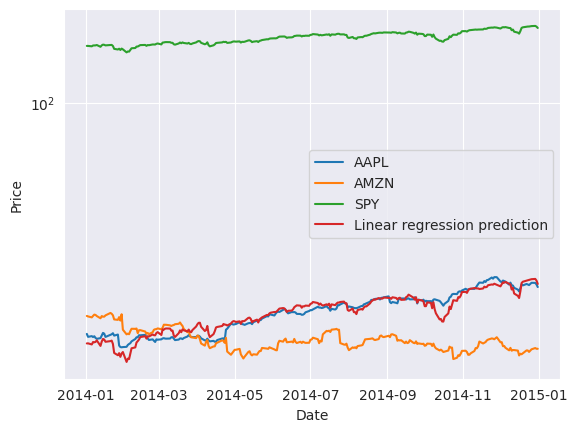

In [42]:
# plot the three variables along with the prediction given by the MLR
sb.lineplot(asset1, label="AAPL")
sb.lineplot(asset2, label="AMZN")
sb.lineplot(benchmark, label="SPY")
sb.lineplot(prediction, label="Linear regression prediction").set(xlabel="Date", ylabel="Price", yscale="log");

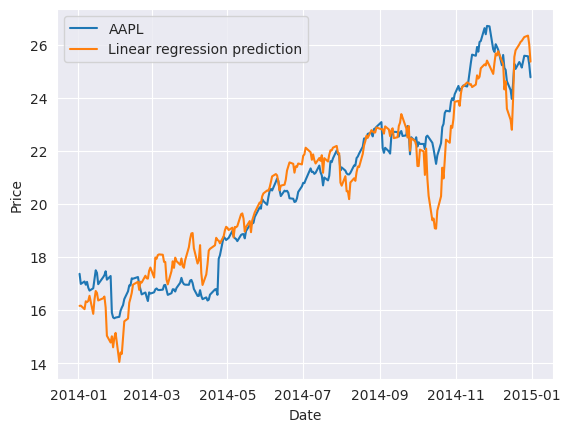

In [43]:
# plot only the dependent variable and the prediction to get a close look
sb.lineplot(asset1, label="AAPL")
sb.lineplot(prediction, label="Linear regression prediction").set(xlabel="Date", ylabel="Price");

## Evaluation

We can get some statistics about the fit from the result returned by the regression:

In [44]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1227.
Date:                Thu, 27 Jul 2023   Prob (F-statistic):          1.17e-129
Time:                        01:24:29   Log-Likelihood:                -341.43
No. Observations:                 252   AIC:                             688.9
Df Residuals:                     249   BIC:                             699.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.7256      2.033    -17.573      0.000     -39.730     -31.722
x1            -0.2259      0.050     -4.537      0.000      -0.324      -0.128
x2             0.3665      0.009     40.381      0.000       0.349       0.384
==============================================================================
Omnibus:                        9.779   Durbin-Watson:                   0.142
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.912
Skew:                           0.479   Prob(JB):                      0.00704
Kurtosis:                       3.158   Cond. No.                     5.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Assumptions

The validity of these statistics depends on whether the assumptions of the linear regression models are satisfied. These are:

- The independent variable is not random.
- The variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
- The errors are not autocorrelated. The *Durbin-Watson* statistic reported by the regression detects this. If it's close to $2$, there is no autocorrelation.
- The errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the F-test.

Multiple linear regression also requires an additional assumption:

- There is no exact linear relationship between the independent variables. Otherwise, it's impossible to solve for the coefficients $\beta_{i}$ uniquely, since the same linear equation can be expressed in multiple ways.

If there's a linear relationship between a set of independent variables (covariance), we say that they are linear combinations of each other. In the case where they are dependent on each other, the values of our $\beta_{i}$ coefficients will be inaccurate for a given $X_i$. The intuition for this can be found in an extreme example where $X_{1}$ and $X_{2}$ are 100% covarying. In that case, the linear regression can equivalently assign the total coefficient sum in any combination without affecting the predictive capability.

$$X_{1} + 0X_{2} = 0.5X_{1} + 0.5X_{2} = 0X_{1} + 1X_{2}$$

While our coefficients may be nondescriptive, the ultimate model can be accurate provided that there's a good fit between the dependent and independent variables. The best practice for constructing a model where dependence is a problem is to leave out the less descriptive variables that are correlated with better ones. This improves the model by reducing the chances of overfitting while bringing the $ß_i$ estimates closer to true values.

If we confirm that the necessary assumptions of the regression model are satisfied, we can use the statistics reported to analyze the fit. E.g. the $R^{2}$ value tells us the fraction of the total variation of $Y$ that is explained by the model. When doing multiple linear regression, however, we prefer to use adjusted $R^{2}$, which corrects for the small increases in $R^{2}$ that occur when we add more regression variables to the model, even if they're not correlated with the dependent variable. Adjusted $R^{2}$ is defined as:

$$1 - (1 - R^{2}) \frac{n-1}{n-k-1}$$

Where $n$ is the number of observations, and $k$ is the number of independent variables in the model. Other useful statistics include the F-statistic and the standard error of estimate.

### Model Selection Example

When deciding on the best possible model of your dependent variables, there are several methods to turn to. If you use too many explanatory variables, you run the risk of overfitting your model, but if you use too few you end up with a terrible fit. One of the best methods, to decide on the best model, is stepwise regression. Forward stepwise regression starts from an empty model and tests each individual variable, selecting the one that results in the best model quality, usually measured with AIC or BIC (the lower, the better). Then it adds the remaining variables one by one, testing each subsequent combination in a regression and calculating the AIC or BIC at each step. At the end of the regression, the model with the best quality (according to the measure) is selected as the final model. However, this has some limitations; it doesn't test every single possible combination, so the theoretical best fit might be written off earlier. As such, stepwise regression should be used in combination with a trader's best judgment.

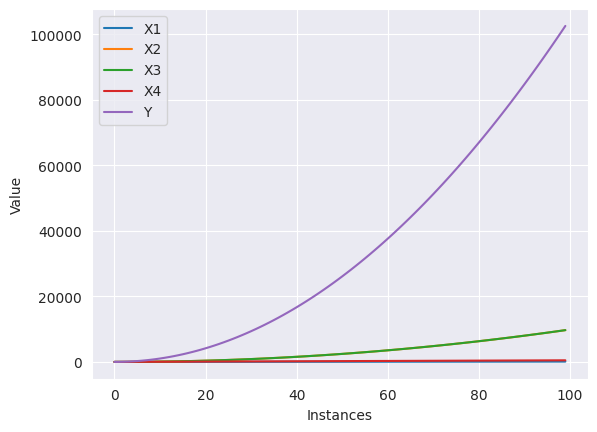

In [45]:
X1 = np.arange(100)
X2 = [i**2 for i in range(100)] - X1
X3 = [np.log(i) for i in range(1, 101)] + X2
X4 = 5 * X1
Y = 2 * X1 + 0.5 * X2 + 10 * X3 + X4
sb.lineplot(X1, label="X1")
sb.lineplot(X2, label="X2")
sb.lineplot(X3, label="X3")
sb.lineplot(X4, label="X4")
sb.lineplot(Y, label="Y").set(xlabel="Instances", ylabel="Value");

In [46]:
results = regression.linear_model.OLS(Y, sm.add_constant(np.column_stack((X1,X2,X3,X4)))).fit()

print("ß0:", results.params[0])
print("ß1:", results.params[1])
print("ß2:", results.params[2])
print("ß3:", results.params[3])
print("ß4:", results.params[4])

ß0: -2.4556356947869062e-11
ß1: 0.26923076923053646
ß2: 0.4999999999886313
ß3: 10.000000000009095
ß4: 1.3461538461538538


In [47]:
data = pd.DataFrame(np.column_stack((X1,X2,X3,X4)), columns = ["X1", "X2", "X3", "X4"])
response = pd.Series(Y, name="Y")

In [48]:
def forward_aic(info):
    # This function will work with pandas dataframes and series

    # Initialize some variables
    explanatory = list(info.columns)
    selected = pd.Series(np.ones(info.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf

    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:

        scores_with_elements = []
        count = 0

        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, info[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(Y, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1

        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, info[best_element]], axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(Y, selected).fit()
    return model

In [49]:
result = forward_aic(data)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.260e+27
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        01:24:29   Log-Likelihood:                 1770.9
No. Observations:                 100   AIC:                            -3534.
Df Residuals:                      96   BIC:                            -3523.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.411e-11   3.47e-09      0.013      0.990   -6.85e-09    6.94e-09
X3            10.0000    2.1e-09   4.76e+09      0.000      10.000      10.000
X1             0.2692   6.42e-12   4.19e+10      0.000       0.269       0.269
X2             0.5000    2.1e-09   2.38e+08      0.000       0.500       0.500
X4             1.3462   3.21e-11   4.19e+10      0.000       1.346       1.346
==============================================================================
Omnibus:                       14.005   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.998
Skew:                           0.649   Prob(JB):                      0.00674
Kurtosis:                       2.155   Cond. No.                     5.01e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.52e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In the construction of this model, the $X_{4}$ term is highly related to the $X_{1}$ term, simply multiplying it by a scalar. However, stepwise regression did not catch this, instead it removed the variable and simply adjusted the coefficient of the $X_{1}$ term. Our judgment would say to leave the $X_{4}$ term out of the model, showing the limitations of stepwise regression.

There are other ways to diagnose the health of a model and individual variables along with varying degrees of penalty given to more complex models.